# wat is de connectie tussen vertragingen en het weer.

dit noteboek is bedoeld voor AI4 semester Fontys ICT, eigen chalange. 

in dit notebook ga ik proberen te achterhallen of het weer een roll speelt met een vertraging in het openbaren trein verkeer.

met deze datasets hoop ik te kunnen vinden of en waar er een goede verbinding is.


in mijn chalage ga ik gebruik maken van phyton pandas, een library om datasets in te laden. ik ga daarnaast ook gebruik maken van plotly om het mooi aan te geven en sklearn voor de machine learning algoritmes.

dependencies voor de chalange:

In [1]:
# dependacies
import os
import numpy as np
# import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
# from geopy.exc import GeocoderTimedOut
# from geopy.geocoders import Nominatim
# from geopy.distance import geodesic

import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import KNNImputer

datafolder = 'data/'

max_data = datetime(2023, 4, 1, 0, 0, 0)

# 📦 Data opzet

nu ben ik op zoek gegaan naar datasets die van belang kunnen zijn in mijn opdracht. 

dit zijn data sets die ik heb gekozen:
- [rijden de trijnen. Treinarchief](https://www.rijdendetreinen.nl/open-data/treinarchief)
- [rijden de trijnen. treinstoringen](https://www.rijdendetreinen.nl/open-data/treinstoringen)
- [rijden de trijnen. trijnstations](https://www.rijdendetreinen.nl/open-data/treinstations)
- [KNMI weerstations Uurwaarnemingen](https://www.daggegevens.knmi.nl/klimatologie/uurgegevens)
- [Train Stations in Europe](https://www.kaggle.com/datasets/headsortails/train-stations-in-europe)


in deze datasets staat het all het trein verkeer, het trein verkeer dat van gezecht word dat het een storing was, het weer in uren en de locatie van het trein station.

### 🚄 treinarchief laden.

de code hieronder laad het trainarchief in. in dit treinarchief hebben we de volgende colomen volgens [rijden de trijnen](https://www.rijdendetreinen.nl/):
- `Service:RDT-ID` Dit ID wordt gebruikt voor deze rit. Het heeft geen nuttige betekenis buiten het uniek identificeren van een enkele rit op een enkele datum.
>Dit ID zal meerdere keren voorkomen in de CSV-bestanden omdat dit ID uniek is voor iedere rit. Er is ook een kolom Stop:RDT-ID met een uniek ID voor iedere stop.
- `Service:Date` De geplande datum voor deze rit.
>De ritdatum is niet altijd de logische datum. Bijvoorbeeld: een rit die vertrekt om 23:59 op 31 juli en aankomt om 02:00 op 1 augustus heeft een ritdatum van 31 juli. Vertragingen hebben geen invloed op de ritdatum.
- `Service:Type` Het soort trein, zoals Intercity, Sprinter of ICE International.
- `Service:Company` Vervoerder die deze rit uitvoert, zoals NS of Arriva.
- `Service:Train number` Het treinnummer (ritnummer) voor deze rit identificeert deze rit uniek op deze datum. Dit nummer wordt soms ook gecommuniceerd naar reizigers (vooral voor internationale treinen). 
> Een enkele rit kan soms meerdere treinnummers hebben. Bijvoorbeeld wanneer een trein gesplitst wordt in twee delen, of wanneer een trein op een groot station halverwege van treinnummer verandert.
- `Service:Completely cancelled` Deze kolom is true wanneer alle stops van deze rit opgeheven zijn. Of met andere woorden: wanneer de trein helemaal niet rijdt.
- `Service:Partly cancelled` Deze kolom is true wanneer een of meer stops van deze rit opgeheven zijn. Of met andere woorden: wanneer de trein niet rijdt op een deel van het traject.
- `Service:Maximum delay` De hoogste vertraging (in minuten) van alle stops van deze rit.
- `Stop:RDT-ID` Unieke ID voor deze stop. Dit ID is uniek voor iedere stop in de dataset. Het heeft verder geen nuttige betekenis.
- `Stop:Station code` Code (verkorting) van de stationsnaam.
- `Stop:Station name` De naam van het station.
- `Stop:Arrival time` Geplande aankomsttijd in RFC 3339-formaat. Deze kolom is leeg wanneer er geen aankomst gepland was.
- `Stop:Arrival delay` Vertraging bij aankomst in minuten. Deze kolom is leeg wanneer er geen aankomst gepland was.
- `Stop:Arrival cancelled` Deze kolom is true wanneer de aankomst op deze stop opgeheven is. Deze kolom is leeg wanneer er geen aankomst gepland was.
- `Stop:Departure time` Geplande vertrektijd in RFC 3339-formaat. Deze kolom is leeg wanneer er geen vertrek gepland was.
- `Stop:Departure delay` Vertraging bij vertrek in minuten. Deze kolom is leeg wanneer er geen vertrek gepland was.
- `Stop:Departure cancelled` Deze kolom is true wanneer het vertrek op deze stop opgeheven is. Deze kolom is leeg wanneer er geen vertrek gepland was.


In de code laad ik de dataset in en verander ik de datum naar een datetime zodat ik hem dan kan verminderen naar het zoekgebied die ik op het moment heb in de weer dataset. daarna zet ik type en bedrijf naar kleine letters omdat de dataset handmatig soms is aangepast en dan worden hoofdletter vergeten.

ik gebruik deze dataset om te kijken welke treinen reden en welke treinen er vertraging hadden.

In [2]:
Train_trafic_2023 = pd.read_csv(datafolder + 'services-2023/services-2023.csv', sep=',', low_memory=False)

Train_trafic_2023['Service:Date'] = pd.to_datetime(Train_trafic_2023['Service:Date'], format="%Y-%m-%d")
Train_trafic_2023 = Train_trafic_2023[Train_trafic_2023['Service:Date'] < max_data]

Train_trafic_2023['Service:Type'] = Train_trafic_2023['Service:Type'].str.lower()
Train_trafic_2023['Service:Company'] = Train_trafic_2023['Service:Company'].str.lower()
Train_trafic_2023['Stop:Station name'] = Train_trafic_2023['Stop:Station name'].str.lower()

# Train_trafic_2023 = Train_trafic_2023[Train_trafic_2023['Service:Company'] == 'ns']


print(f'er zijn {len(Train_trafic_2023)} entries ingeladen') 

er zijn 5142250 entries ingeladen


### 🌥️ KNMI Uurwaarnemingen laden

in de code hieronder laad ik de uurwaarneming van het weer in. dit is waarom meerendeels van het project alleen over de eerse 2 maanden van het project gaan. <p>
in de dataset van het weer hebben we:
- `STN` dit is het weer station nummer
- `YYYYMMDD` datum (YYYY=jaar;MM=maand;DD=dag)
- `start_time` tijd (HH=uur; UT.12 UT=13 MET; 14 MEZT. Uurvak 05 loopt van 04.00 UT tot 5.00 UT)
- `DD` Windrichting (in graden) gemiddeld over de laatste 10 minuten van het afgelopen uur (360=noord; 90=oost; 180=zuid; 270=west; 0=windstil 990=veranderlijk.
- `FH` Uurgemiddelde windsnelheid (in 0.1 m/s).
- `FF` Windsnelheid (in 0.1 m/s) gemiddeld over de laatste 10 minuten van het afgelopen uur.
- `FX` Hoogste windstoot (in 0.1 m/s) over het afgelopen uurvak.
- `temp` Temperatuur (in 0.1 graden Celsius) op 1.50 m hoogte tijdens de waarneming.
- `T10N` Minimumtemperatuur (in 0.1 graden Celsius) op 10 cm hoogte in de afgelopen 6 uur.
- `TD` Dauwpuntstemperatuur (in 0.1 graden Celsius) op 1.50 m hoogte tijdens de waarneming.
- `SQ` Duur van de zonneschijn (in 0.1 uren) per uurvak; berekend uit globale straling  (-1 for <0.05 uur).
- `Q` Globale straling (in J/cm2) per uurvak.
- `DR` Duur van de neerslag (in 0.1 uur) per uurvak.
- `RH` Uursom van de neerslag (in 0.1 mm) (-1 voor <0.05 mm).
- `P` Luchtdruk (in 0.1 hPa) herleid naar zeeniveau; tijdens de waarneming.
- `VV` Horizontaal zicht tijdens de waarneming (0=minder dan 100m; 1=100-200m; 2=200-300m;...; 49=4900-5000m; 50=5-6km; 56=6-7km; 57=7-8km; ...; 79=29-30km; 80=30-35km; 81=35-40km;...; 89=meer dan 70km).
- `N` Bewolking (bedekkingsgraad van de bovenlucht in achtsten); tijdens de waarneming (9=bovenlucht onzichtbaar).
- `U` Relatieve vochtigheid (in procenten) op 1.50 m hoogte tijdens de waarneming.
- `WW` Weercode (00-99); visueel(WW) of automatisch(WaWa) waargenomen; voor het actuele weer of het weer in het afgelopen uur.
- `IX` Weercode indicator voor de wijze van waarnemen op een bemand of automatisch station (1=bemand gebruikmakend van code uit visuele waarnemingen; 2;3=bemand en weggelaten (geen belangrijk weersverschijnsel; geen gegevens); 4=automatisch en opgenomen (gebruikmakend van code uit visuele waarnemingen); 5;6=automatisch en weggelaten (geen belangrijk weersverschijnsel; geen gegevens); 7=automatisch gebruikmakend van code uit automatische waarnemingen).
- `M` Mist 0=niet voorgekomen; 1=wel voorgekomen in het voorgaande uur en/of tijdens de waarneming.
- `R` Regen 0=niet voorgekomen; 1=wel voorgekomen in het voorgaande uur en/of tijdens de waarneming.
- `S` Sneeuw 0=niet voorgekomen; 1=wel voorgekomen in het voorgaande uur en/of tijdens de waarneming.
- `O` Onweer 0=niet voorgekomen; 1=wel voorgekomen in het voorgaande uur en/of tijdens de waarneming.
- `Y` IJsvorming 0=niet voorgekomen; 1=wel voorgekomen in het voorgaande uur en/of tijdens de waarneming.


hier laad ik het weer in dat en zet de start_time of de start tijd naar een datetime. daarby combineer ik twee colommen om een datum en tijd in 1 colom te krijgen.

ik gebruik deze dataset om het weer van een bepaalde datum en station nummer te krijgen.

In [3]:
weather_2023 = pd.read_csv(datafolder + '2023-jan-mar.csv', sep=',', low_memory=False, encoding='utf-8', skiprows=80)

weather_2023['start_time'] = weather_2023['start_time'].astype(str) + ' ' + (weather_2023['HH'] - 1).astype(str) + ':00:00'

weather_2023['start_time'] = pd.to_datetime(weather_2023['start_time'], format="%Y%m%d %H:%M:%S")
#  drop columns that are not needed
# weather_2023 = weather_2023.drop(columns=['HH', 'WW', 'IX', 'FH', 'FX', 'TD', 'SQ', 'RH'])
weather_2023 = weather_2023.drop(columns=['HH'])

print(f'er zijn {len(weather_2023)} entries ingeladen') 

er zijn 99360 entries ingeladen


de weer dataset bestaat uit 2 datasets. de gene hierboven die voor de gegevens uit de weer stations.
en de gene hieronder die gaat over de weer station Locaties.


de weer station locatie dataset heeft de collomen:
- `STN` dit is het weer station nummer.
- `LON(east)` dit is de longitude van het weer station.
- `LAT(north)` dit is de latitude van het weer station.
- `ALT(m)` dit is de hoogte waarop het station staat.
- `NAME` de naam van waar het weer station staat.

met deze gegevens hoop ik te achterhalen wat het weer was het station van aankoms.

de dataset van het weer heeft de locatie op bassis van station nummer.

In [4]:
weather_station_location = pd.read_csv(datafolder + 'Weather-stations-loc.csv', sep=',', low_memory=False, encoding='utf-8')
print(f'er zijn {len(weather_station_location)} entries ingeladen') 

er zijn 50 entries ingeladen


### 🏟️ trein station 

in de dataset hieronder zitten alle trein stations van europa. ik zal minder nodig hebben dus zal met de country alleen nederland, duitserland en belgie gaan houden. dit is ook omdat mijn andere datasets niet verder kijken dan die locaties.

in deze dataset zit:
- `id` de primary sleutel van de data.
- `name` Naam van het station zoals het lokaal bekend is. Deze namen bevatten accenten en andere speciale tekens.
- `name_norm` De gelatiniseerde versie van de naam.
- `uic` International Union of Railways (UIC) code.
- `latitude` Coordinates
- `longitude` Coordinates
- `parent_station_id` A station can belong to a meta station whose `id` is this value.
- `country` Landcodes in ISO 3166-1 alpha-2 formaat (2 cijfers).
- `time_zone` Continent/Land ISO-codes. Deze lijken equivalent te zijn aan Olson-namen (bijvoorbeeld “Europe/Berlin”).
- `is_city` Gemarkeerd als “onbetrouwbaar” in de bron dataset.
- `is_main_station` 
- `is_airport` 
- `entur_id` 
- `entur_is_enabled` 

ik zal deze dataset gebruiken om de locaties van de trein stations te vinden. <p>
en aangezien ik alleen de locaties hoef te hebben zal ik die ook allen onthouden. naast de belangerijke data zoals Namen die het kunnen zijn en in welk land ze zitten.

met de hulp van deze gegevens hoop ik de gaten in mijn gegevens te vullen. 


In [5]:
train_station_locations = pd.read_csv(datafolder + 'train_stations_europe.csv', low_memory=False, encoding='utf-8')

train_station_locations = train_station_locations.drop(columns=['id', 'uic', 'parent_station_id', 'time_zone', 'is_city', 'is_main_station', 'is_airport', 'entur_id', 'entur_is_enabled'])

# europa_train_station_locations['country'] = pd.Categorical(europa_train_station_locations['country'], categories=['NL', 'DE', 'BE'], ordered=True)
# europa_train_station_locations = europa_train_station_locations[europa_train_station_locations['country'].notna()]

train_station_locations['name'] = train_station_locations['name'].str.lower()

print(f'er zijn {len(train_station_locations)} entries ingeladen') 

er zijn 64037 entries ingeladen


ik ben er later achter gekomen dat rijden de trijnen ook de trijn stations megeeft dus ik zal deze dataset gebruiken.

deze dataset hoop ik te kunnen gebruiken in een manier waarop ik kan vergelijken waar een station zich begeeft.

in deze dataset staat:
- `rdt_id` Intern ID gebruikt door Rijden de Treinen.
- `code` De unieke verkorting (afkorting) van het station. Meestal is het een afkorting van de stationsnaam, maar de naam is niet altijd herkenbaar (bijvoorbeeld de meeste stations in Den Haag). Een stationcode is maximaal 8 tekens lang.
- `uic` De UIC-code van een station. Dit is een internationaal uniek identificatienummer voor stations. Nederlandse stations hebben een UIC-code die begint met 84 (bijvoorbeeld 8400058 voor Amsterdam Centraal).
- `name_short` Korte version van de stationsnaam. Vaak wordt een groot deel van de stationsnaam weggelaten (bijvoorbeeld Scienceprk in plaats van Amsterdam Science Park).
- `name_medium` De middellange versie van de stationsnaam. Deze versie van de stationsnaam wordt vaak gebruikt wanneer er geen ruimte is voor de volledige naam, maar kan ook niet alle naamselementen bevatten (bijvoorbeeld Science Park in plaats van Amsterdam Science Park).
- `name_long` De lange (of volledige) stationsnaam.
- `slug` Unieke naam voor het station, in kleine letters en zonder spaties. Dit is hetzelfde als de URL van de stationspagina op de Rijden de Treinen website.
- `country` Het land waarin het station zich bevindt. NL is Nederland, D is Duitsland, B is België, F is Frankrijk, A is Oostenrijk, CH is Zwitserland, GB is het Verenigd Koninkrijk.
- `type` Het soort station. Mogelijke waarden zijn (van groot naar klein station): megastation, knooppuntIntercitystation, intercitystation, knooppuntSneltreinstation, sneltreinstation, knooppuntStoptreinstation, stoptreinstation, facultatiefStation. De categorie knooppunt impliceert dat deze stations bedoeld zijn voor het overstappen op een andere trein. Een facultatiefStation is een station waar normaal gesproken geen treinen stoppen, behalve bij speciale gelegenheden (zoals voetbalwedstrijden).
- `geo_lat` Breedtegraad van het station, in decimale graden.
- `geo_lng` Lengtegraad van het station, in decimale graden.

In [6]:
train_station_locations = pd.read_csv(datafolder + 'stations-2023-09.csv', low_memory=False, encoding='utf-8')

print(f'er zijn {len(train_station_locations)} entries ingeladen') 

er zijn 591 entries ingeladen


# 📃 Sample de data

om even naar de data te kijken ga ik 20 van iedere dataset hieronder laden. dit is om te kijken of het wel goed is ingeladen en dat de data er een beetje werkzaam uitziet.

### 🚄 treinarchief laden.

hier laad ik de samples van het trein verkeer.
en ik laat daaronder ook even zien of er NULL variables zitten in de dataset. bij dit treinarchief maaken NULL variabelen niet out want dat heeft namelijk ook een belangerijke reden. deze reden is dat een NULL gewoon betekend dat het niet voorkwam en aangezien een vertraging die NULL is is gewoon dat er geen vertraging is vermeld.

In [7]:
sample_size = 20

display(Train_trafic_2023.sample(sample_size))
display(Train_trafic_2023.isna().sum())

Service:RDT-ID Service:Date          Service:Type Service:Company  \
5040861        10905419   2023-03-30              sprinter              ns   
1439219        10517393   2023-01-26              sprinter              ns   
1648430        10540980   2023-01-30             intercity              ns   
4164574        10813565   2023-03-15      intercity direct          ns int   
3152570        10701945   2023-02-25              sprinter        blauwnet   
3480585        10740978   2023-03-03             stoptrein        blauwnet   
4479348        10845574   2023-03-21              sprinter              ns   
2816151        10665605   2023-02-17  stopbus i.p.v. trein              ns   
285887         10397245   2023-01-06             stoptrein          arriva   
3369549        10728572   2023-03-01             intercity              ns   
15519          10369318   2023-01-01             sneltrein          arriva   
197751         10388251   2023-01-04             stoptrein              db   
1896239        10566358   2023-02-03              sprinter              ns   
2878869        10672717   2023-02-20              sprinter              ns   
3281519        10718564   2023-02-27  stopbus i.p.v. trein              ns   
1295425        10502616   2023-01-24             intercity              ns   
4093354        10806368   2023-03-14              sprinter        blauwnet   
1426832        10516107   2023-01-26             intercity              ns   
2054189        10584651   2023-02-06             intercity              ns   
167556         10385196   2023-01-04              sprinter              ns   

         Service:Train number  Service:Completely cancelled  \
5040861                  5147                         False   
1439219                  8962                         False   
1648430                  3955                         False   
4164574                  9236                          True   
3152570                  8551                         False   
3480585                  8021                          True   
4479348                  5814                         False   
2816151                983108                         False   
285887                  37839                         False   
3369549                  3038                         False   
15519                   37345                         False   
197751                  20229                         False   
1896239                  4952                         False   
2878869                  7383                         False   
3281519                985172                         False   
1295425                   646                         False   
4093354                  7932                          True   
1426832                  3558                         False   
2054189                  3558                         False   
167556                   6637                         False   

         Service:Partly cancelled  Service:Maximum delay  Stop:RDT-ID  \
5040861                     False                      0     98113586   
1439219                     False                      0     94512022   
1648430                     False                      0     94721236   
4164574                      True                      0     97237348   
3152570                     False                      0     96225153   
3480585                      True                      0     96553382   
4479348                     False                      0     97552159   
2816151                     False                      0     95888959   
285887                      False                      0     93358691   
3369549                     False                      0     96442345   
15519                       False                      1     93083901   
197751                      False                      0     93270561   
1896239                     False                      0     94969022   
2878869                 

Service:RDT-ID                       0
Service:Date                         0
Service:Type                         0
Service:Company                      0
Service:Train number                 0
Service:Completely cancelled         0
Service:Partly cancelled             0
Service:Maximum delay                0
Stop:RDT-ID                          0
Stop:Station code                 6632
Stop:Station name                    0
Stop:Arrival time               551049
Stop:Arrival delay              551049
Stop:Arrival cancelled          551049
Stop:Departure time             550943
Stop:Departure delay            550943
Stop:Departure cancelled        550943
dtype: int64

### 🌥️ KNMI Uurwaarnemingen laden
hieronder laad ik de samples can de weerstations, em de weer station locaties. dit heb ik nodig om later te kijken welk weer station het dichts bij het trein station is. 
en daaronder kijk ik hoeveel NULL variables er zijn. dit betekend bij bijna alle collomen dat een weer station geen sensor ervoor heeft. 
T10N is anders want deze wordt elk 6 uur opgenomen daardoor is alle andere rows die ertussen zitten NULL. dit is natuurlijk als het weer station een temperatuut sensor heeft.

In [8]:
display(weather_2023.sample(sample_size))
display(weather_station_location.sample(sample_size))


display(weather_2023.isna().sum())
display(weather_station_location.isna().sum())


STN          start_time     DD     FH    FF     FX   temp   T10N  \
37372  277 2023-01-28 04:00:00  210.0   20.0  30.0   40.0   21.0    NaN   
59673  312 2023-02-26 09:00:00   70.0  100.0  90.0  130.0    NaN    NaN   
86926  356 2023-01-22 22:00:00   10.0   20.0  20.0   30.0    9.0    NaN   
92909  377 2023-01-02 05:00:00  210.0   70.0  70.0  120.0  123.0  117.0   
2934   215 2023-02-02 06:00:00  270.0   80.0  80.0  120.0   81.0    NaN   
75107  330 2023-03-11 11:00:00  220.0   10.0  20.0   40.0   70.0   10.0   
43421  280 2023-01-10 05:00:00  210.0   50.0  40.0   90.0   58.0    9.0   
47664  285 2023-01-07 00:00:00  190.0   80.0  80.0   90.0    NaN    NaN   
22426  258 2023-02-04 10:00:00  360.0   10.0  10.0   20.0    NaN    NaN   
30117  269 2023-03-26 21:00:00   10.0   40.0  40.0   60.0   52.0    NaN   
34747  275 2023-01-08 19:00:00  160.0   50.0  40.0   90.0   71.0    NaN   
28519  269 2023-01-19 07:00:00  290.0   40.0  30.0   80.0   42.0    NaN   
98995  391 2023-03-16 19:00:00  140.0   40.0  40.0   70.0   90.0    NaN   
37772  277 2023-02-13 20:00:00  110.0   30.0  30.0   40.0   46.0    NaN   
13128  248 2023-01-08 00:00:00  210.0  100.0  90.0  130.0    NaN    NaN   
14136  248 2023-02-19 00:00:00  270.0   60.0  60.0  100.0    NaN    NaN   
11832  242 2023-02-13 00:00:00  180.0   30.0  30.0   40.0   65.0    NaN   
28308  269 2023-01-10 12:00:00  190.0   60.0  60.0   90.0   66.0    NaN   
7242   235 2023-02-01 18:00:00  290.0   90.0  80.0  140.0   74.0    NaN   
68285  319 2023-02-25 05:00:00  320.0   40.0  40.0   80.0   44.0   19.0   

          TD    SQ  ...    VV    N     U    WW  IX    M    R    S    O    Y  
37372   -2.0   0.0  ...   NaN  NaN  84.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
59673    NaN   NaN  ...   NaN  NaN   NaN   NaN   6  NaN  NaN  NaN  NaN  NaN  
86926    3.0   0.0  ...   NaN  NaN  95.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
92909  104.0   0.0  ...  70.0  8.0  88.0  61.0   7  0.0  1.0  0.0  0.0  0.0  
2934    54.0   0.0  ...  64.0  8.0  83.0  22.0   7  0.0  1.0  0.0  0.0  0.0  
75107  -24.0  10.0  ...   NaN  NaN  51.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
43421   51.0   0.0  ...  61.0  8.0  95.0  23.0   7  0.0  1.0  0.0  0.0  0.0  
47664    NaN   NaN  ...   NaN  NaN   NaN   NaN   6  NaN  NaN  NaN  NaN  NaN  
22426    NaN   NaN  ...   NaN  NaN   NaN   NaN   6  NaN  NaN  NaN  NaN  NaN  
30117    1.0   0.0  ...  80.0  8.0  69.0   NaN   5  0.0  0.0  0.0  0.0  0.0  
34747   41.0   0.0  ...  70.0  3.0  81.0   NaN   5  0.0  0.0  0.0  0.0  0.0  
28519   11.0   0.0  ...  75.0  8.0  80.0   NaN   5  0.0  0.0  0.0  0.0  0.0  
98995   28.0   0.0  ...   NaN  NaN  64.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
37772   38.0   0.0  ...   NaN  NaN  94.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
13128    NaN   NaN  ...   NaN  NaN   NaN   NaN   6  NaN  NaN  NaN  NaN  NaN  
14136    NaN   NaN  ...   NaN  NaN   NaN   NaN   6  NaN  NaN  NaN  NaN  NaN  
11832   23.0   NaN  ...  70.0  8.0  74.0   NaN   5  0.0  0.0  0.0  0.0  0.0  
28308   40.0   0.0  ...  66.0  8.0  83.0   NaN   5  0.0  0.0  0.0  0.0  0.0  
7242    44.0   0.0  ...  64.0  6.0  81.0   NaN   5  0.0  0.0  0.0  0.0  0.0  
68285   12.0   0.0  ...  75.0  NaN  79.0   0.0   7  0.0  0.0  0.0  0.0  0.0  

[20 rows x 24 columns]

STN  LON(east)  LAT(north)  ALT(m)                NAME
12  260      5.180      52.100     1.9              DeBilt
49  391      6.197      51.498    19.5               Arcen
32  315      3.998      51.447     0.0           Hansweert
40  343      4.313      51.893     3.5  RotterdamGeulhaven
31  313      3.242      51.505     0.0     VlaktevanDeRaan
20  278      6.259      52.435     3.6               Heino
47  377      5.763      51.198    30.0                 Ell
3   225      4.555      52.463     4.4            IJmuiden
27  308      3.379      51.381     0.0             Cadzand
19  277      6.200      53.413     2.9          Lauwersoog
41  344      4.447      51.962    -4.3           Rotterdam
17  273      5.888      52.703    -3.3           Marknesse
15  269      5.520      52.458    -3.7            Lelystad
18  275      5.873      52.056    48.2              Deelen
48  380      5.762      50.906   114.3          Maastricht
37  330      4.122      51.992    11.9      HoekvanHolland
0   209      4.518      52.465     0.0              IJmond
38  331      4.193      51.480     0.0              Tholen
29  311      3.672      51.379     0.0          Hoofdplaat
25  286      7.150      53.196    -0.2         NieuwBeerta

STN               0
start_time        0
DD             2499
FH             2500
FF             2499
FX             2500
temp          25920
T10N          87120
TD            25920
SQ            30240
Q             30240
DR            28081
RH            28080
P             47520
VV            45361
N             56160
U             25920
WW            73164
IX                0
M             45415
R             45415
S             45415
O             45415
Y             45415
dtype: int64

STN           0
LON(east)     0
LAT(north)    0
ALT(m)        0
NAME          0
dtype: int64

### 🏟️ trein station 
hier laad ik de samples van de trein stations. en het ziet ernaar uit dat ik geen nulls heb. dus dat is goed. 

In [9]:
display(train_station_locations.sample(sample_size))

display(train_station_locations.isna().sum())

id    code      uic  name_short       name_medium  \
378  632    ENBE  8021147   Münster-H     Münster-Häger   
26    24    AMFS  8400054  Schothorst        Schothorst   
104  109     BTL  8400129      Boxtel            Boxtel   
67   764     BNZ  8400115  Barnevld Z    Barneveld Zuid   
68    59  BASELB  8014431   Basel Bad      Basel Bad Bf   
8     12    AIME  8774176  Aime-la-Pl    Aime-la-Plagne   
35    48    ASSP  8400235  Scienceprk      Science Park   
148  230    HDRZ  8400303  Dn Heldr Z   Den Helder Zuid   
186  174    EMNZ  8400407     Emmen Z        Emmen Zuid   
46    32    APDM  8400233    De Maten          De Maten   
83   563  BIELEF  8013597   Bielefeld     Bielefeld Hbf   
347  315     LTN  8400405    Lunteren          Lunteren   
479  447     STV  8400575    Stavoren          Stavoren   
13    26     AMR  8400050     Alkmaar           Alkmaar   
307  692     KKD  8015561  Köln Messe  Köln Messe/Deutz   
470  423     SDT  8400565  Sliedrecht        Sliedrecht   
491  458      TL  8400596        Tiel              Tiel   
198  165     EGH  8400338   Eygelshov       Eygelshoven   
578  526      ZA  8400734  Zetten-And    Zetten-Andelst   
559  522      WW  8400698   Winterswk       Winterswijk   

                  name_long                    slug country  \
378           Münster-Häger           munster-hager       D   
26    Amersfoort Schothorst   amersfoort-schothorst      NL   
104                  Boxtel                  boxtel      NL   
67           Barneveld Zuid          barneveld-zuid      NL   
68             Basel Bad Bf            basel-bad-bf       D   
8            Aime-la-Plagne          aime-la-plagne       F   
35   Amsterdam Science Park  amsterdam-science-park      NL   
148         Den Helder Zuid         den-helder-zuid      NL   
186              Emmen Zuid              emmen-zuid      NL   
46       Apeldoorn De Maten      apeldoorn-de-maten      NL   
83            Bielefeld Hbf           bielefeld-hbf       D   
347                Lunteren                lunteren      NL   
479                Stavoren                stavoren      NL   
13                  Alkmaar                 alkmaar      NL   
307        Köln Messe/Deutz         koln-messedeutz       D   
470              Sliedrecht              sliedrecht      NL   
491                    Tiel                    tiel      NL   
198             Eygelshoven             eygelshoven      NL   
578          Zetten-Andelst          zetten-andelst      NL   
559             Winterswijk             winterswijk      NL   

                          type    geo_lat   geo_lng  
378           stoptreinstation  52.022327  7.562668  
26            stoptreinstation  52.174822  5.403889  
104  knooppuntStoptreinstation  51.584330  5.319120  
67            stoptreinstation  52.128853  5.602460  
68            stoptreinstation  47.568150  7.607300  
8             intercitystation  45.554380  6.648690  
35            stoptreinstation  52.355260  4.946510  
148           stoptreinstation  52.932499  4.764167  
186           sneltreinstation  52.748866  6.874781  
46            stoptreinstation  52.205276  6.000556  
83            stoptreinstation  52.029261  8.532722  
347           stoptreinstation  52.085278  5.624444  
479           stoptreinstation  52.886553  5.360021  
13   knooppuntIntercitystation  52.637779  4.739722  
307                megastation  50.940874  6.975001  
470           stoptreinstation  51.829723  4.778333  
491  knooppuntStoptreinstation  51.889446  5.422222  
198           stoptreinstation  50.890556  6.045000  
578           stoptreinstation  51.920056  5.722841  
559  knooppuntStoptreinstation  51.967731  6.715518

id             0
code           1
uic            0
name_short     0
name_medium    0
name_long      0
slug           0
country        0
type           0
geo_lat        0
geo_lng        0
dtype: int64

# 🔍 vooronderzoek

aangezien ik meerdere datasets heb moet ik als eers even kijken waar de vertragingen zitten.

hiervoor maak ik een pie chard en kijk ik wat er de vertragingen zijn.

### 🚄 trein verkeer 
in het trein verkeer is het belangerijk om te weten dat als er null staat dan heeft het nog steeds een betekenis. 

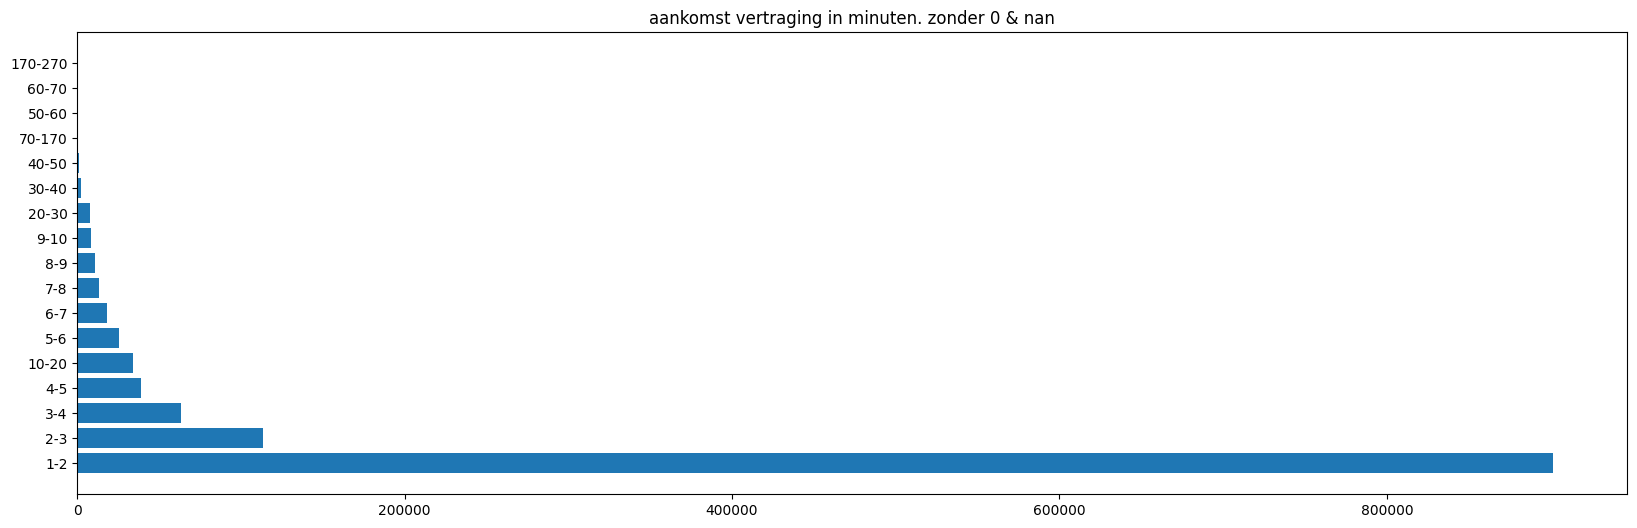

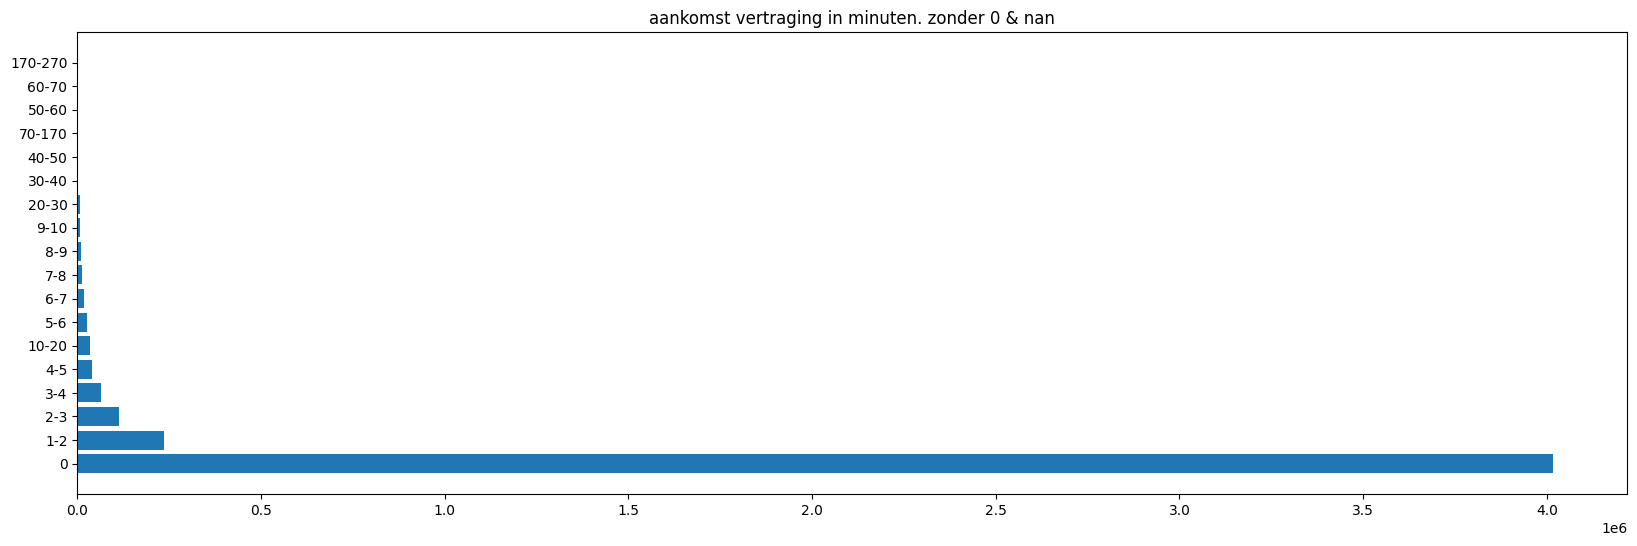

In [10]:
bins =  list(range(1, 10, 1)) + list(range(10, 70, 10)) + list(range(70, int(Train_trafic_2023['Stop:Departure delay'].max()) +100, 100))

labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]

counts = pd.cut(Train_trafic_2023['Stop:Departure delay'], bins=bins, labels=labels, include_lowest=True).dropna().astype(str).value_counts(sort=True)

plt.figure(figsize=(20,6))
plt.barh( counts.index, counts)
plt.title(label='aankomst vertraging in minuten. zonder 0 & nan')
plt.show()

labels = ['0'] + labels

bins = [0] + bins 

counts = pd.cut(Train_trafic_2023['Stop:Departure delay'], bins=bins, labels=labels, include_lowest=True).dropna().astype(str).value_counts(sort=True)

plt.figure(figsize=(20,6))
plt.barh( counts.index, counts)
plt.title(label='aankomst vertraging in minuten. zonder 0 & nan')
plt.show()

in de chards hierboven is in te lezen dat de meeste treinen op tijd weggaan van hun locatie. houd nogmaals rekening dat 0 en nan allebij zeggen dat er geen vertraging vermeld is.

en als ik de nan en 0 weg haal is de vertraging voornamelijk binnen de 10 minuten.

maar dit hierboven is alleen de vertrek vertraging. hieronder heb ik de aankomst vertraging op de zelfde manier gedaan.

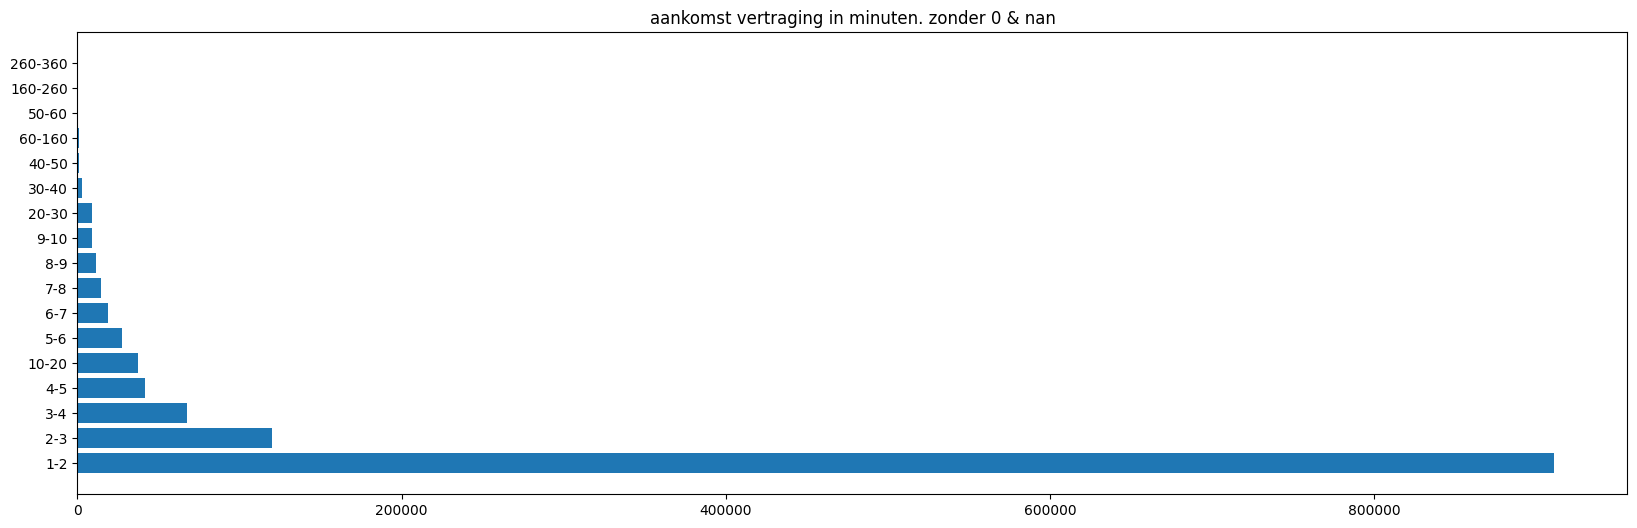

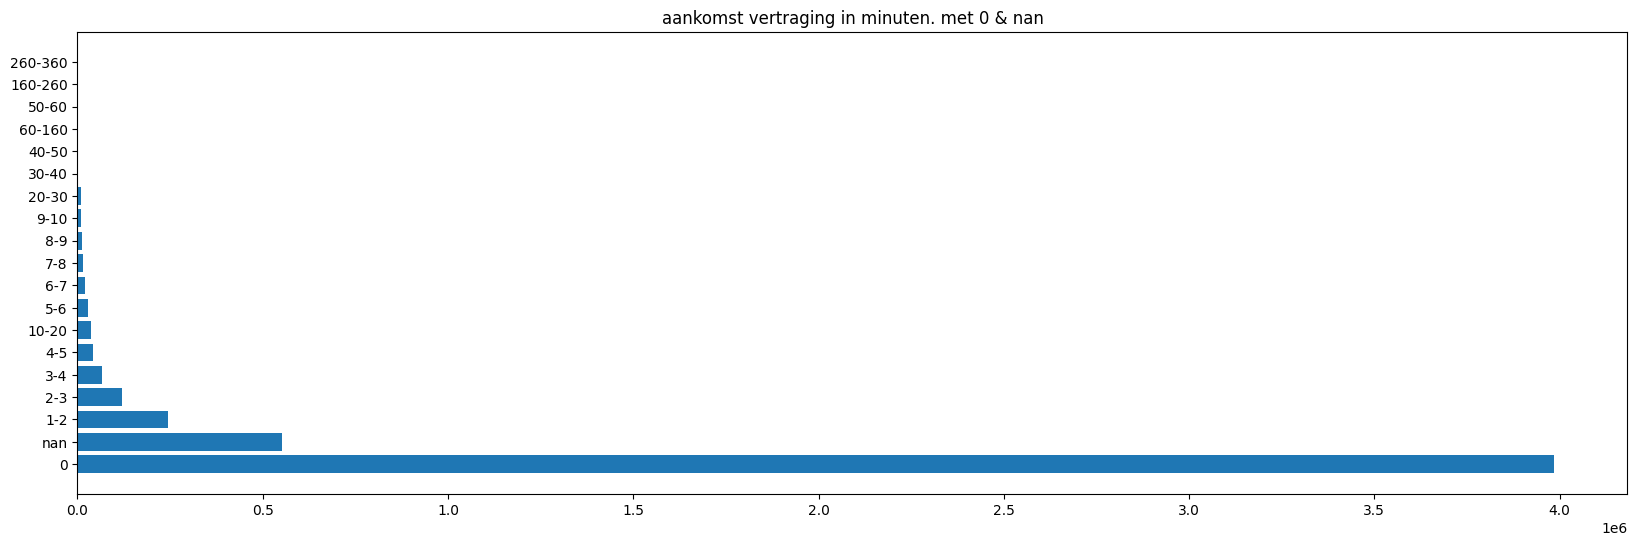

In [11]:
bins = list(range(1, 10, 1)) + list(range(10, 60, 10)) + list(range(60, int(Train_trafic_2023['Stop:Arrival delay'].max()) +100, 100))

labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]

counts = pd.cut(Train_trafic_2023['Stop:Arrival delay'], bins=bins, labels=labels, include_lowest=True).dropna().astype(str).value_counts(sort=True)

plt.figure(figsize=(20,6))
plt.barh( counts.index, counts)
plt.title(label='aankomst vertraging in minuten. zonder 0 & nan')
plt.show()

labels = ['0'] + labels 

bins = [0] + bins

counts = pd.cut(Train_trafic_2023['Stop:Arrival delay'], bins=bins, labels=labels, include_lowest=True).astype(str).value_counts(sort=True)

plt.figure(figsize=(20,6))
plt.barh( counts.index, counts)
plt.title(label='aankomst vertraging in minuten. met 0 & nan')
plt.show()

als ik naar wat de vier chards zeggen lijken ze goed evereen te komen. dit betekend dat meestal als een trein te laat binnen komt zal hij waarschijnlijk ook te laat vertrekken.

met de table tabel hieronder zal ik kijken of er op een bepaalde lijn meer vertragin is dan op een ander. hiervoor moet ik wel oppassen en kijken of ik niet te vaak de zelfde lijn meenemen. \
aangezien der is aangegeven dat een RDT-ID meerdere keren kan voorkomen op vershcillende dagen moet ik eers even alles goed bij elkaar zetten. \
en ik pak de mean omdat ik de average vertaging van de ritten op een dag zien.

Service:Date  Stop:Arrival delay
0    2023-01-01            0.680368
1    2023-01-02            0.596654
2    2023-01-03            0.565669
3    2023-01-04            0.781114
4    2023-01-05            0.673781
..          ...                 ...
85   2023-03-27            0.799672
86   2023-03-28            0.964126
87   2023-03-29            0.642580
88   2023-03-30            0.710096
89   2023-03-31            0.702228

[90 rows x 2 columns]

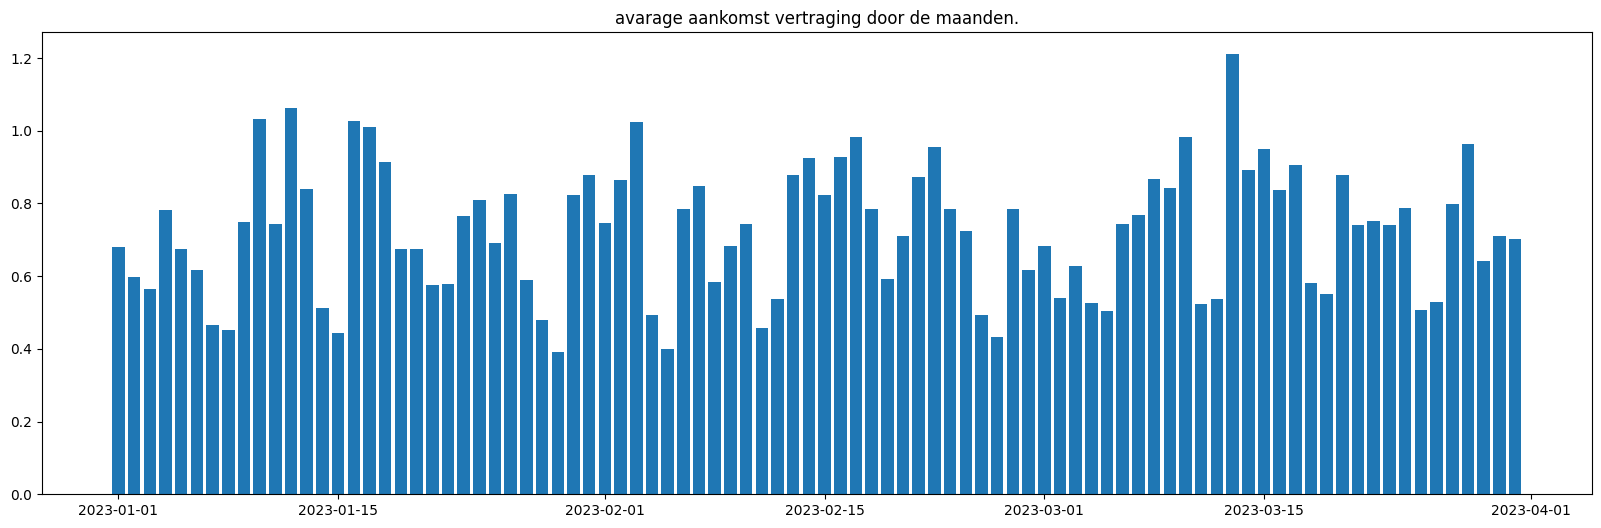

In [12]:
grouped = Train_trafic_2023.groupby(['Service:Date', 'Service:RDT-ID'])['Stop:Arrival delay'].mean()

df_avarage_delay_day = grouped.reset_index(name='Stop:Arrival delay')

grouped = df_avarage_delay_day.groupby(['Service:Date'])['Stop:Arrival delay'].mean()

df_avarage_delay_day = grouped.reset_index(name='Stop:Arrival delay')

display(df_avarage_delay_day)

plt.figure(figsize=(20,6))
plt.bar( df_avarage_delay_day['Service:Date'], df_avarage_delay_day['Stop:Arrival delay'])
plt.title(label='avarage aankomst vertraging door de maanden.')
plt.show()

in te grafiek hierboven is te zien dat de avarage aankomst vertaging schommeeld door de maanden. \
dit kan belangerijk zijn voor het testen van omstandigheden met het weer.

### 🌥️ het weer
in het weer bestaan veel colomen en ik kijk even wat er nodig is en wat niet. daarvoor ga ik het gemidelde berekenene en kijken hoe ver ik daarmee van het antwoord. als het in de buurt zit kan ik zeggen dat de avarage goed is voor nederland als het niet zo is moet ik even kijken wat ik dan ga doen.


In [13]:
grouped = weather_2023.groupby(by=['start_time']).mean()

db_weather_single_day = grouped.reset_index()

db_weather_single_day = db_weather_single_day.drop(columns=['STN'])

display(db_weather_single_day.head(24))

df_first_date = weather_2023[weather_2023['start_time'] == weather_2023['start_time'].min()]

display(df_first_date[df_first_date['temp'].notna()].sort_values('temp'))


start_time          DD          FH          FF          FX  \
0  2023-01-01 00:00:00  215.555556  110.666667  110.000000  172.222222   
1  2023-01-01 01:00:00  215.333333  108.000000  106.444444  167.333333   
2  2023-01-01 02:00:00  220.222222  107.333333  106.888889  168.000000   
3  2023-01-01 03:00:00  223.111111  104.000000  103.333333  165.111111   
4  2023-01-01 04:00:00  224.444444   99.111111   99.111111  158.444444   
5  2023-01-01 05:00:00  224.666667   95.333333   94.222222  148.444444   
6  2023-01-01 06:00:00  224.666667   91.333333   89.555556  140.222222   
7  2023-01-01 07:00:00  222.666667   87.111111   83.777778  134.444444   
8  2023-01-01 08:00:00  219.111111   81.777778   81.555556  127.555556   
9  2023-01-01 09:00:00  215.111111   76.666667   76.444444  119.555556   
10 2023-01-01 10:00:00  216.222222   78.444444   80.222222  120.000000   
11 2023-01-01 11:00:00  218.444444   78.666667   77.777778  122.888889   
12 2023-01-01 12:00:00  218.666667   77.555556   74.222222  119.555556   
13 2023-01-01 13:00:00  212.222222   68.000000   63.777778  107.555556   
14 2023-01-01 14:00:00  201.555556   59.111111   54.888889   92.666667   
15 2023-01-01 15:00:00  190.000000   52.000000   49.777778   82.000000   
16 2023-01-01 16:00:00  182.000000   48.888889   49.777778   76.666667   
17 2023-01-01 17:00:00  176.000000   49.111111   49.555556   78.222222   
18 2023-01-01 18:00:00  172.000000   49.333333   49.555556   78.444444   
19 2023-01-01 19:00:00  173.555556   48.222222   48.222222   78.222222   
20 2023-01-01 20:00:00  187.333333   41.333333   40.666667   76.222222   
21 2023-01-01 21:00:00  167.555556   40.444444   40.000000   73.777778   
22 2023-01-01 22:00:00  172.000000   41.777778   43.555556   70.000000   
23 2023-01-01 23:00:00  171.777778   43.777778   42.444444   72.444444   

          temp        T10N         TD       SQ         Q  ...     VV     N  \
0   140.617647         NaN  80.382353  0.00000   0.00000  ...  73.28  8.00   
1   138.029412         NaN  80.764706  0.00000   0.00000  ...  74.28  8.00   
2   135.529412         NaN  79.941176  0.00000   0.00000  ...  74.12  8.00   
3   131.323529         NaN  80.911765  0.00000   0.00000  ...  73.20  7.95   
4   125.970588         NaN  79.970588  0.00000   0.00000  ...  73.88  8.00   
5   122.558824  114.294118  76.294118  0.00000   0.00000  ...  73.08  8.00   
6   117.941176         NaN  75.352941  0.00000   0.00000  ...  70.80  8.00   
7   113.647059         NaN  75.970588  0.00000   0.25000  ...  69.88  8.00   
8   112.441176         NaN  78.558824  0.18750   5.62500  ...  69.40  8.00   
9   114.911765         NaN  81.676471  2.62500  25.12500  ...  69.56  8.00   
10  118.764706         NaN  83.588235  3.25000  40.75000  ...  70.64  7.90   
11  120.529412  102.852941  84.882353  1.46875  42.56250  ...  71.48  7.95   
12  121.382353         NaN  84.088235  2.00000  38.59375  ...  71.24  8.00   
13  119.647059         NaN  83.529412  1.06250  23.28125  ...  71.04  8.00   
14  116.352941         NaN  83.352941  1.15625  10.03125  ...  70.52  8.00   
15  113.617647         NaN  83.647059  0.00000   1.18750  ...  69.88  8.00   
16  111.058824         NaN  86.264706  0.00000   0.00000  ...  68.64  8.00   
17  108.735294  100.294118  89.058824  0.00000   0.00000  ...  67.32  8.00   
18  105.764706         NaN  92.147059  0.00000   0.00000  ...  65.08  8.00   
19  104.058824         NaN  93.617647  0.00000   0.00000  ...  62.68  8.00   
20  101.941176         NaN  93.500000  0.00000   0.00000  ...  60.88  8.00   
21  102.264706         NaN  94.764706  0.00000   0.00000  ...  61.36  8.00   
22  105.029412         NaN  95.470588  0.00000   0.00000  ...  60.68  8.00   
23  107.970588   95.647059  96.911765  0.00000   0.00000  ...  59.48  8.00   

            U         WW        IX    M     R    S    O    Y  
0   67.558824  36.062500  6.152174  0.0  0.56  0.0  0.0  0.0  
1   68.941176  49.187500  6.152174  0.0  0.64  0.0  0.0  0.0  
2   69.764706  30.631

STN start_time     DD     FH     FF     FX   temp  T10N    TD   SQ  \
17280  251 2023-01-01  220.0  140.0  130.0  190.0  108.0   NaN  88.0  0.0   
6480   235 2023-01-01  220.0  120.0  120.0  180.0  112.0   NaN  95.0  0.0   
10800  242 2023-01-01  220.0  160.0  150.0  210.0  114.0   NaN  91.0  NaN   
25920  267 2023-01-01  220.0  130.0  130.0  200.0  121.0   NaN  89.0  0.0   
19440  257 2023-01-01    NaN    NaN    NaN    NaN  123.0   NaN  83.0  0.0   
49680  286 2023-01-01  210.0  110.0  100.0  170.0  128.0   NaN  98.0  0.0   
36720  277 2023-01-01  220.0  120.0  130.0  200.0  130.0   NaN  92.0  0.0   
32400  273 2023-01-01  220.0   80.0   70.0  130.0  131.0   NaN  93.0  0.0   
56160  310 2023-01-01  200.0  140.0  140.0  180.0  131.0   NaN  79.0  0.0   
30240  270 2023-01-01  230.0  140.0  140.0  230.0  132.0   NaN  94.0  0.0   
43200  280 2023-01-01  210.0  110.0  100.0  190.0  133.0   NaN  94.0  0.0   
73440  330 2023-01-01  210.0  130.0  120.0  210.0  135.0   NaN  78.0  0.0   
15120  249 2023-01-01  230.0  140.0  130.0  230.0  136.0   NaN  98.0  0.0   
8640   240 2023-01-01  220.0  110.0  110.0  150.0  138.0   NaN  92.0  0.0   
41040  279 2023-01-01  220.0   90.0   90.0  150.0  139.0   NaN  92.0  0.0   
28080  269 2023-01-01  220.0  100.0  110.0  170.0  141.0   NaN  90.0  0.0   
2160   215 2023-01-01  220.0  110.0  130.0  200.0  142.0   NaN  84.0  0.0   
79920  344 2023-01-01  210.0  100.0  110.0  180.0  143.0   NaN  88.0  0.0   
66960  319 2023-01-01  210.0  100.0   90.0  180.0  145.0   NaN  74.0  0.0   
69120  323 2023-01-01  210.0   90.0   90.0  160.0  145.0   NaN  80.0  0.0   
95040  380 2023-01-01  210.0  100.0   90.0  150.0  147.0   NaN  42.0  0.0   
82080  348 2023-01-01  220.0  120.0  130.0  180.0  147.0   NaN  82.0  0.0   
75600  340 2023-01-01  220.0   70.0   80.0  140.0  148.0   NaN  72.0  NaN   
38880  278 2023-01-01  220.0   70.0   60.0  130.0  150.0   NaN  83.0  0.0   
86400  356 2023-01-01  220.0  110.0  110.0  170.0  151.0   NaN  80.0  0.0   
51840  290 2023-01-01  210.0   80.0   70.0  150.0  152.0   NaN  72.0  0.0   
34560  275 2023-01-01  220.0  100.0   90.0  150.0  153.0   NaN  76.0  0.0   
45360  283 2023-01-01  210.0   70.0   70.0  130.0  154.0   NaN  72.0  0.0   
84240  350 2023-01-01  210.0   90.0   90.0  150.0  154.0   NaN  73.0  0.0   
23760  260 2023-01-01  220.0   80.0  100.0  160.0  155.0   NaN  75.0  0.0   
92880  377 2023-01-01  210.0   90.0   80.0  160.0  155.0   NaN  53.0  0.0   
90720  375 2023-01-01  220.0  110.0  110.0  160.0  162.0   NaN  66.0  0.0   
88560  370 2023-01-01  220.0  110.0  120.0  190.0  163.0   NaN  59.0  0.0   
97200  391 2023-01-01  220.0   50.0   50.0  120.0  163.0   NaN  56.0  0.0   

       ...    VV    N     U    WW  IX    M    R    S    O    Y  
17280  ...  58.0  NaN  87.0  10.0   7  0.0  0.0  0.0  0.0  0.0  
6480   ...  56.0  8.0  89.0  52.0   7  0.0  1.0  0.0  0.0  0.0  
10800  ...  57.0  8.0  86.0  10.0   7  0.0  0.0  0.0  0.0  0.0  
25920  ...  64.0  8.0  81.0  57.0   7  0.0  1.0  0.0  0.0  0.0  
19440  ...   NaN  NaN  76.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
49680  ...   NaN  NaN  82.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
36720  ...   NaN  NaN  78.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
32400  ...  64.0  NaN  77.0  23.0   7  0.0  1.0  0.0  0.0  0.0  
56160  ...  75.0  8.0  70.0   NaN   5  0.0  0.0  0.0  0.0  0.0  
30240  ...  74.0  8.0  78.0  23.0   7  0.0  1.0  0.0  0.0  0.0  
43200  ...  71.0  8.0  77.0  23.0   7  0.0  1.0  0.0  0.0  0.0  
73440  ...   NaN  NaN  68.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
15120  ...  63.0  NaN  77.0  81.0   7  0.0  1.0  0.0  0.0  0.0  
8640   ...  69.0  8.0  73.0  81.0   7  0.0  1.0  0.0  0.0  0.0  
41040  ...  75.0  8.0  73.0  51.0   7  0.0  1.0  0.0  0.0  0.0  
28080  ...  67.0  8.0  71.0  23.0   7  0.0  1.0  0.0  0.0  0.0  
2160   ...  66.0  8.0  68.0   NaN   5  0.0  0.0  0.0  0.0  0.0  
79920  ...  79.0  8.0  69.0   NaN   5  0.0  0.0  0.0  0.0  0.0  
66960  ...  81.0  NaN  62.0   NaN   5  0.0  0.0  0.0  0.0  0.0  
69120  ... 

het ziet er naar out dat met de temperatuur het er uit ziet dat er een ~4 grade verschil tussen de hoogste en laagste temperatuur. \
en wel 4 grade verschill niet veel is kan het er tot leiden dat mijn data niet meer klopt. dus het ziet er naar uit dat ik toch het verschill tussen de stations moet vinden en de dichtsbijzijnde weer station.

### 🏟️ trein station 

ik moet als eers erachter komen welke trein stations ik nodig heb voor mijn datasets. en dat is wat ik hieronder doe. \
ik pak de station codes van het trein verkeer en de codes van de train station in de locatie dataset en kijk welke er in zitten.

In [14]:
train_station_locations = train_station_locations[train_station_locations['code'].isin(Train_trafic_2023['Stop:Station code'])]

display(train_station_locations)

id  code      uic  name_short       name_medium              name_long  \
0    266    HT  8400319   Den Bosch  's-Hertogenbosch       's-Hertogenbosch   
1    269   HTO  8400320  Dn Bosch O  's-Hertogenb. O.  's-Hertogenbosch Oost   
2    227   HDE  8400388    't Harde          't Harde               't Harde   
3      8  AHBF  8015345      Aachen        Aachen Hbf             Aachen Hbf   
4    818    AW  8015199    Aachen W       Aachen West            Aachen West   
..   ...   ...      ...         ...               ...                    ...   
585  677   ZUE  8503000   Zürich HB         Zürich HB              Zürich HB   
586  534    ZP  8400744     Zutphen           Zutphen                Zutphen   
587  541   ZWD  8400752  Zwijndrcht       Zwijndrecht            Zwijndrecht   
589  532    ZL  8400747      Zwolle            Zwolle                 Zwolle   
590  815  ZLSH  8400746  Stadshagen        Stadshagen      Zwolle Stadshagen   

                     slug country                       type    geo_lat  \
0         s-hertogenbosch      NL  knooppuntIntercitystation  51.690480   
1    s-hertogenbosch-oost      NL           stoptreinstation  51.700554   
2                 t-harde      NL           stoptreinstation  52.409168   
3              aachen-hbf       D  knooppuntIntercitystation  50.767800   
4             aachen-west       D           stoptreinstation  50.780360   
..                    ...     ...                        ...        ...   
585             zurich-hb      CH           intercitystation  47.378190   
586               zutphen      NL  knooppuntIntercitystation  52.145279   
587           zwijndrecht      NL           stoptreinstation  51.814999   
589                zwolle      NL  knooppuntIntercitystation  52.504723   
590     zwolle-stadshagen      NL           stoptreinstation  52.527640   

      geo_lng  
0    5.293620  
1    5.318333  
2    5.893611  
3    6.091499  
4    6.070715  
..        ...  
585  8.539200  
586  6.194167  
587  4.641667  
589  6.091944  
590  6.051460  

[546 rows x 11 columns]

met deze informatie kan ik mijn trein stations coördinaten geven zodat ik de dichtsbijzijnde weer station kan gebruiken.

maar om dat te testen doe ik hier eerst een test gebaseerd op 1 meetpunt moment.

hier gebrouk ik de BellTree funktie van de neighbors functies van sklearn. hiermee probeer ik de tempraturen van de stations te ontdekken.

de metric haversine is een goede metric omdat de afstand uit te calculeren tussen twee locaties.

ik moet allen voor de haversine metric de ingaande informatie omzetten naar de radians vorm, gelukkig heeft numpy daar een goede funkie voor.

uitijndelijk doe ik dit om een zo dicht mogelijk weer station te krijgen. want dit heb ik nodig om te bepalen of de trein verkeer vertragingen een verbinding hebben met het weer.

In [15]:
from sklearn.neighbors import BallTree

df_mergid_first_date_stations = df_first_date.merge(weather_station_location, on='STN', how='inner')

df_mergid_first_date_stations[['LAT(north)_radians', 'LON(east)_radians']] = np.radians(df_mergid_first_date_stations[['LAT(north)', 'LON(east)']])
train_station_locations[['geo_lat_radians', 'geo_lng_radians']] = np.radians(train_station_locations[['geo_lat', 'geo_lng']])

tree = BallTree(df_mergid_first_date_stations[['LAT(north)_radians', 'LON(east)_radians']].dropna().values, metric='haversine')

indices = tree.query(train_station_locations[['geo_lat_radians', 'geo_lng_radians']].dropna().values, return_distance=False, k=1)

nearest_neighbors_weather_station_location = df_mergid_first_date_stations.iloc[indices.flatten()]

train_station_locations.reset_index(drop=True, inplace=True)
nearest_neighbors_weather_station_location.reset_index(drop=True, inplace=True)

combined_df = pd.concat([nearest_neighbors_weather_station_location, train_station_locations], axis=1)

display(combined_df.drop(columns=['geo_lat_radians', 'geo_lng_radians', 'LAT(north)_radians', 'LON(east)_radians', 'name_short', 'name_medium', 'name_long', 'id', 'code', 'uic']))


STN start_time     DD     FH     FF     FX   temp  T10N    TD   SQ  ...  \
0    356 2023-01-01  220.0  110.0  110.0  170.0  151.0   NaN  80.0  0.0  ...   
1    356 2023-01-01  220.0  110.0  110.0  170.0  151.0   NaN  80.0  0.0  ...   
2    278 2023-01-01  220.0   70.0   60.0  130.0  150.0   NaN  83.0  0.0  ...   
3    380 2023-01-01  210.0  100.0   90.0  150.0  147.0   NaN  42.0  0.0  ...   
4    380 2023-01-01  210.0  100.0   90.0  150.0  147.0   NaN  42.0  0.0  ...   
..   ...        ...    ...    ...    ...    ...    ...   ...   ...  ...  ...   
541  380 2023-01-01  210.0  100.0   90.0  150.0  147.0   NaN  42.0  0.0  ...   
542  275 2023-01-01  220.0  100.0   90.0  150.0  153.0   NaN  76.0  0.0  ...   
543  344 2023-01-01  210.0  100.0  110.0  180.0  143.0   NaN  88.0  0.0  ...   
544  278 2023-01-01  220.0   70.0   60.0  130.0  150.0   NaN  83.0  0.0  ...   
545  278 2023-01-01  220.0   70.0   60.0  130.0  150.0   NaN  83.0  0.0  ...   

       Y  LON(east)  LAT(north)  ALT(m)        NAME                  slug  \
0    NaN      5.146      51.859     0.7   Herwijnen       s-hertogenbosch   
1    NaN      5.146      51.859     0.7   Herwijnen  s-hertogenbosch-oost   
2    NaN      6.259      52.435     3.6       Heino               t-harde   
3    0.0      5.762      50.906   114.3  Maastricht            aachen-hbf   
4    0.0      5.762      50.906   114.3  Maastricht           aachen-west   
..   ...        ...         ...     ...         ...                   ...   
541  0.0      5.762      50.906   114.3  Maastricht             zurich-hb   
542  0.0      5.873      52.056    48.2      Deelen               zutphen   
543  0.0      4.447      51.962    -4.3   Rotterdam           zwijndrecht   
544  NaN      6.259      52.435     3.6       Heino                zwolle   
545  NaN      6.259      52.435     3.6       Heino     zwolle-stadshagen   

     country                       type    geo_lat   geo_lng  
0         NL  knooppuntIntercitystation  51.690480  5.293620  
1         NL           stoptreinstation  51.700554  5.318333  
2         NL           stoptreinstation  52.409168  5.893611  
3          D  knooppuntIntercitystation  50.767800  6.091499  
4          D           stoptreinstation  50.780360  6.070715  
..       ...                        ...        ...       ...  
541       CH           intercitystation  47.378190  8.539200  
542       NL  knooppuntIntercitystation  52.145279  6.194167  
543       NL           stoptreinstation  51.814999  4.641667  
544       NL  knooppuntIntercitystation  52.504723  6.091944  
545       NL           stoptreinstation  52.527640  6.051460  

[546 rows x 33 columns]

uit de test hierboven can ik valideren dat ik met de weer stations en trein station locaties redelijk goed de dichtsbijzijnde weerstation van een trein station kan vinden.

# 🎛️ corrilatie bekijken.

hier ga ik de corrilatie plots van de datasets neerzetten.

### 🚄 trein verkeer 
dit is de correlatie plot van het trijn verkeer

<Axes: >

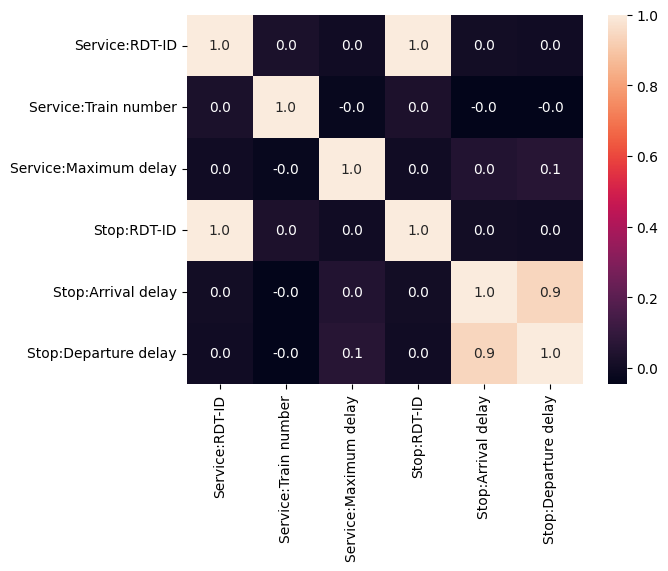

In [16]:
corr = Train_trafic_2023.select_dtypes(include=['int32', 'int64', 'float64']).corr()

sns.heatmap(corr, cbar=True, annot=True, fmt=".1f")

het ziet er naar uit als ik de losse trein informatie cor plot geeft het een lage corelatie met elkaar. \
hieronder ga ik een pairplot maken om te kijken of ik er iets meer uit kan maken.

<Figure size 2000x2000 with 0 Axes>

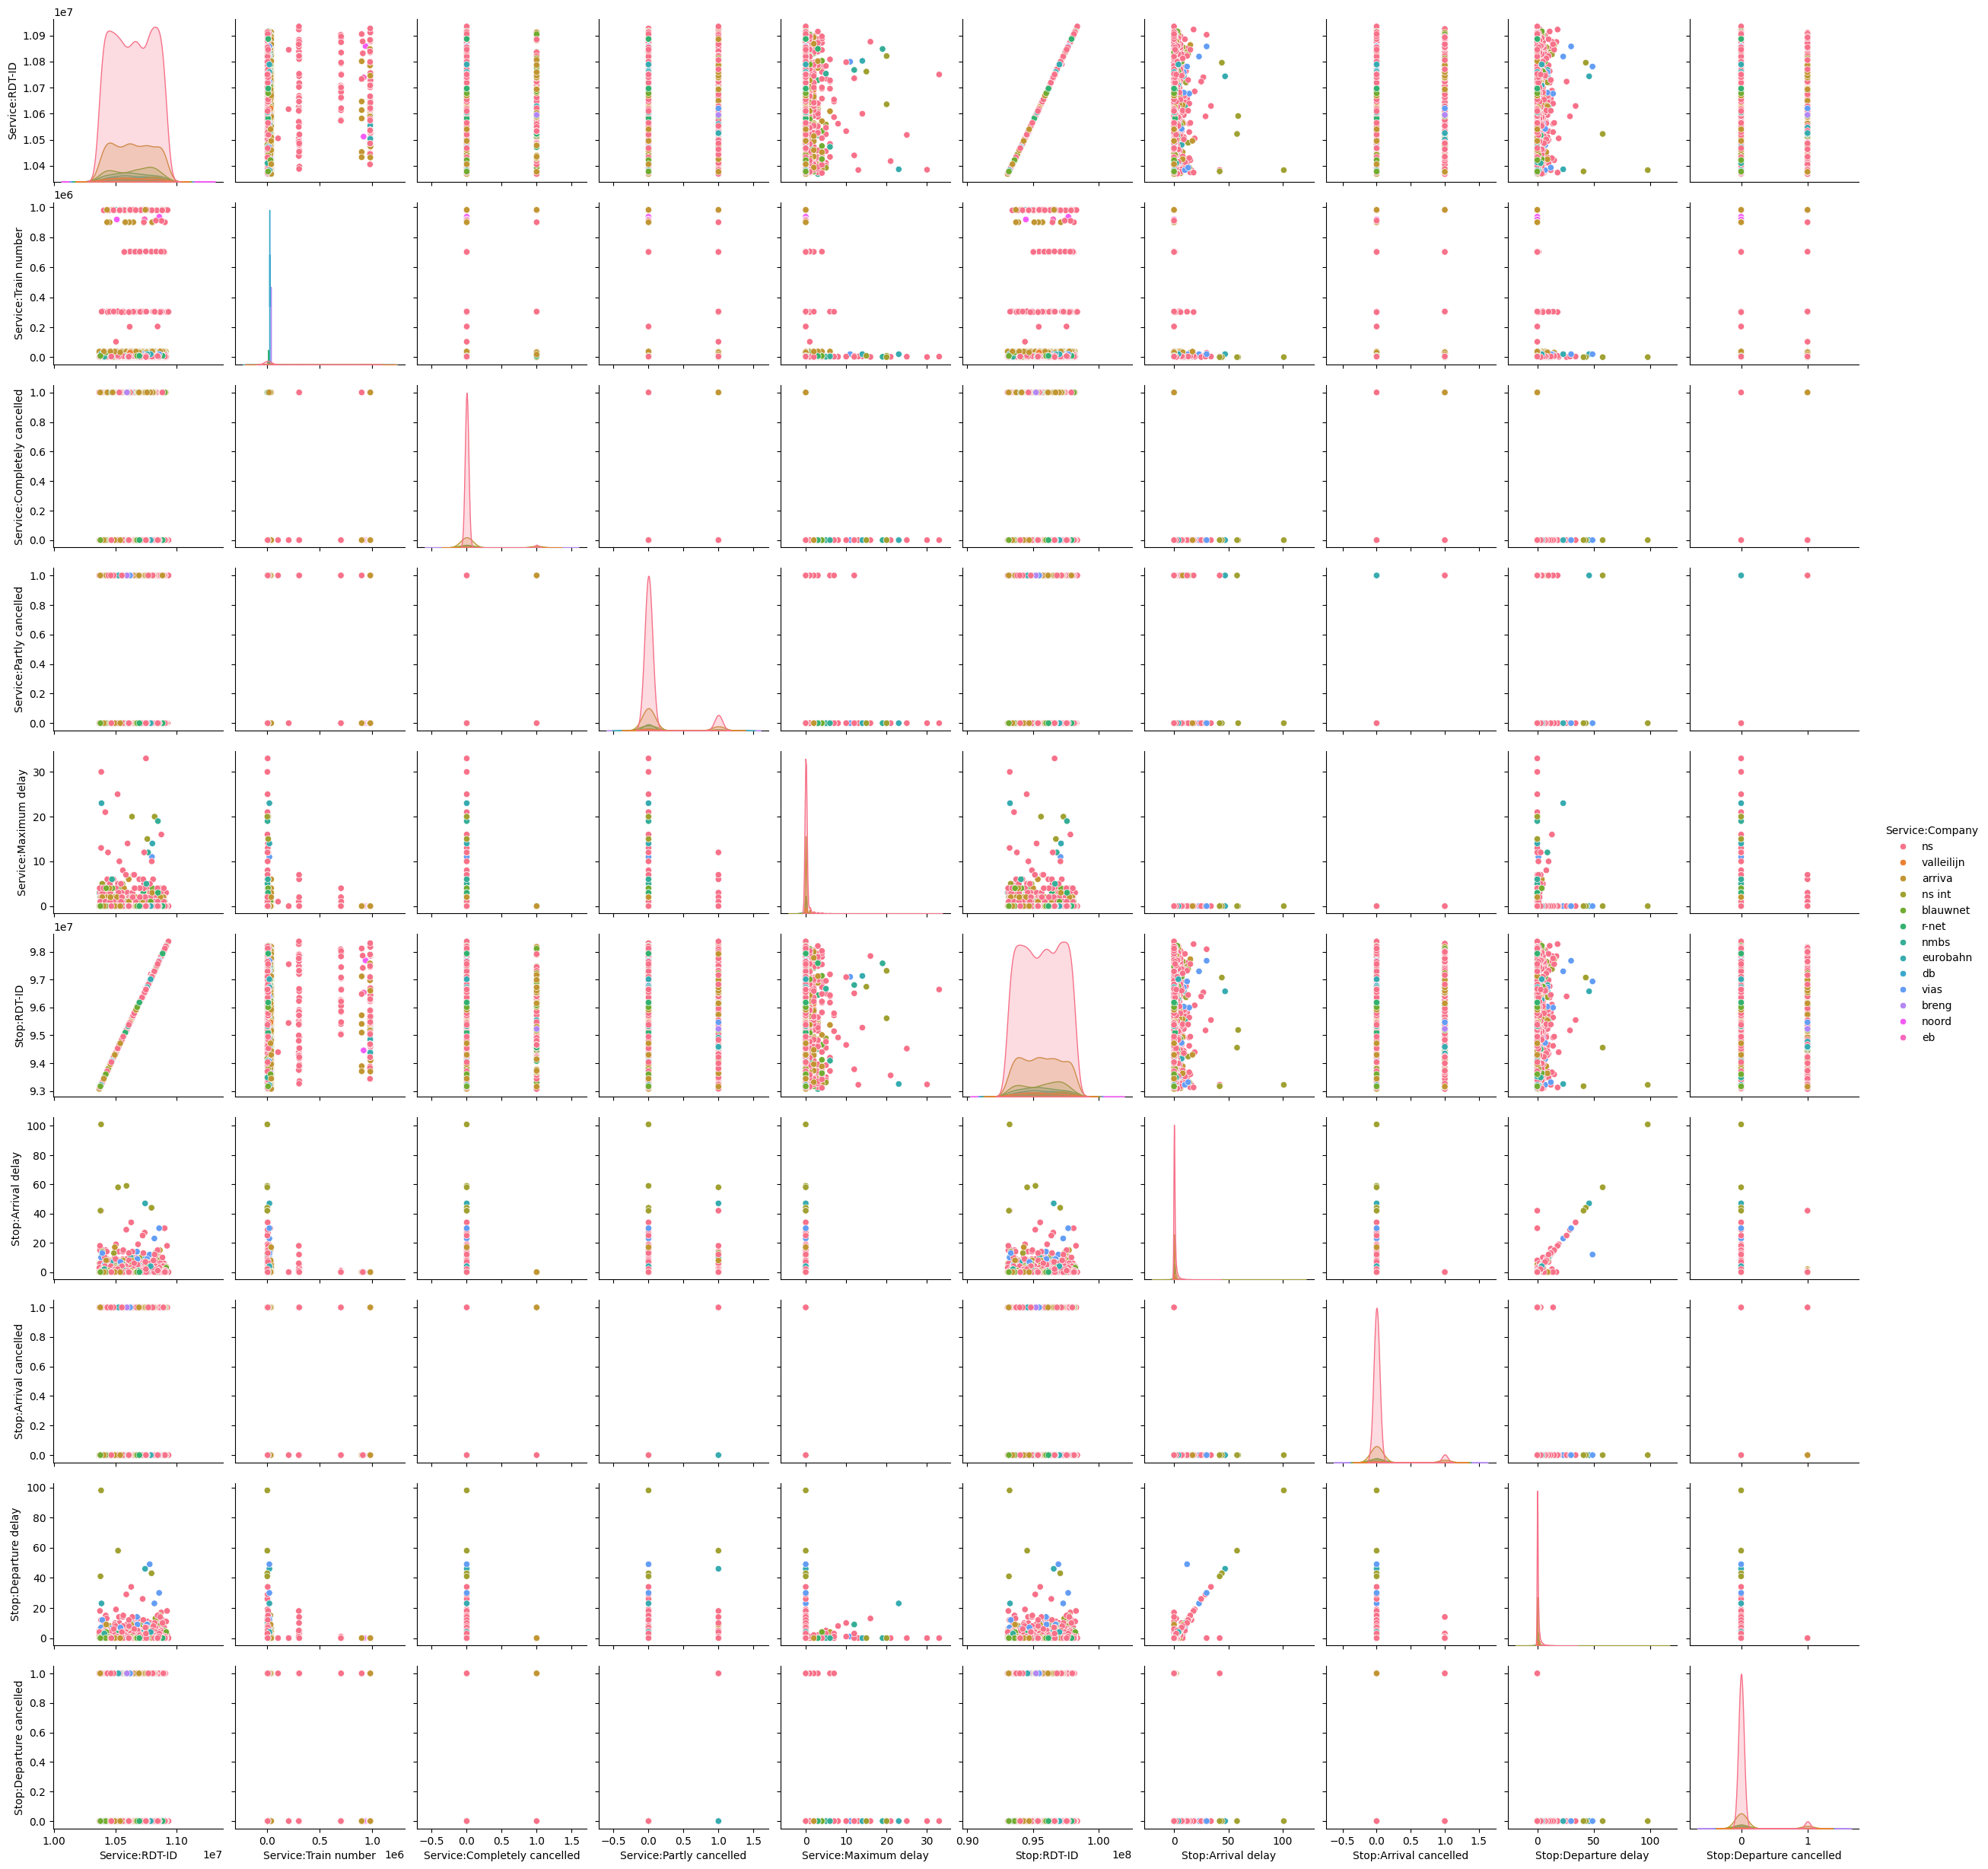

In [22]:
plt.figure(figsize=(20,20))
sns.pairplot(Train_trafic_2023.sample(frac=0.001), hue='Service:Company')

terwijl ik de hoeveelheid heb moeten verkleinen krijg ik er well een goed gevoel over wat er in mijn dataset zit.

### 🌥️ het weer

<Axes: >

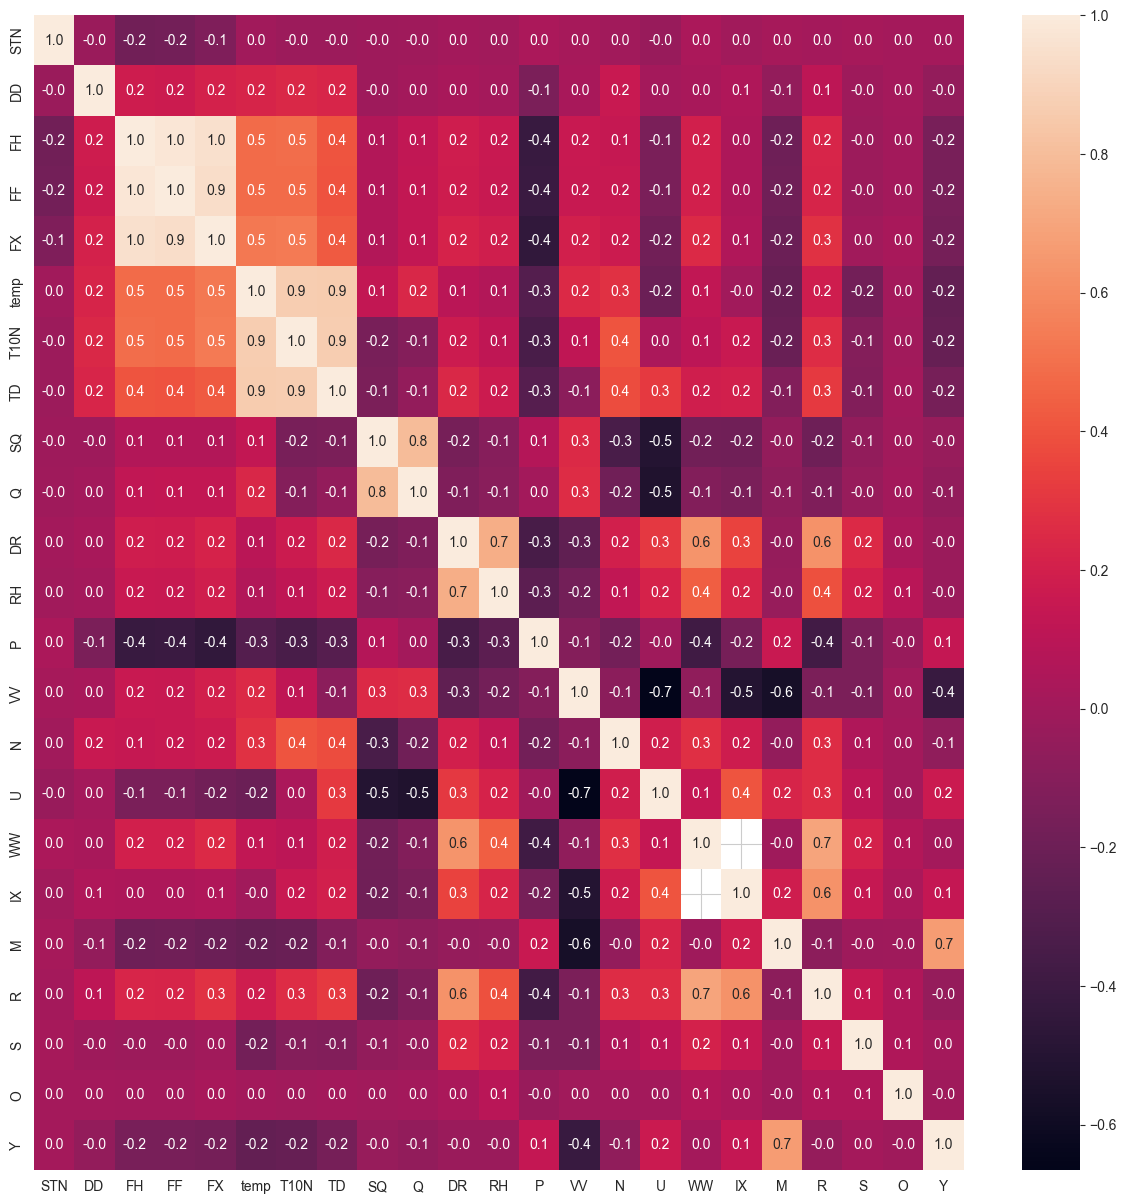

In [206]:
plt.subplots(figsize=(15, 15))

corr = weather_2023.select_dtypes(include=['int32', 'int64', 'float64']).corr()

sns.heatmap(corr, cbar=True, annot=True, fmt=".1f",)

het ziet er naar uit dat het weer een grote relatie heeft met elkaar. niet alleen even veel maar de dingen die met elkaar te maken horen te hebben doen. zoals de temperatuur en de minimale temperatuur elk 6 uur hebben een grote correlatie.

STN          start_time     DD    FH    FF     FX   temp  T10N    TD  \
15291  249 2023-01-08 03:00:00  190.0  50.0  50.0   70.0   81.0   NaN  66.0   
67142  319 2023-01-08 14:00:00  190.0  60.0  60.0  110.0   96.0   NaN  53.0   
34284  273 2023-03-20 12:00:00  210.0  50.0  50.0   90.0   82.0   NaN  69.0   
4943   225 2023-01-26 23:00:00   30.0  80.0  80.0  100.0    NaN   NaN   NaN   
52115  290 2023-01-12 11:00:00  220.0  80.0  70.0  120.0  101.0  82.0  93.0   
...    ...                 ...    ...   ...   ...    ...    ...   ...   ...   
62497  313 2023-03-26 01:00:00  210.0  70.0  60.0  100.0    NaN   NaN   NaN   
48435  285 2023-02-08 03:00:00  180.0  50.0  50.0   60.0    NaN   NaN   NaN   
8858   240 2023-01-10 02:00:00  250.0  70.0  70.0  100.0   73.0   NaN  53.0   
32472  273 2023-01-04 00:00:00  190.0  90.0  90.0  140.0   84.0   NaN  71.0   
60990  313 2023-01-22 06:00:00   30.0  80.0  80.0  110.0    NaN   NaN   NaN   

        SQ  ...    VV    N     U    WW  IX    M    R    S    O    Y  
15291  0.0  ...  70.0  NaN  90.0   NaN   5  0.0  0.0  0.0  0.0  0.0  
67142  7.0  ...  75.0  NaN  74.0   NaN   5  0.0  0.0  0.0  0.0  0.0  
34284  0.0  ...  65.0  NaN  91.0  81.0   7  0.0  1.0  0.0  0.0  0.0  
4943   NaN  ...   NaN  NaN   NaN   NaN   6  NaN  NaN  NaN  NaN  NaN  
52115  0.0  ...  30.0  8.0  94.0  58.0   7  0.0  1.0  0.0  0.0  0.0  
...    ...  ...   ...  ...   ...   ...  ..  ...  ...  ...  ...  ...  
62497  NaN  ...   NaN  NaN   NaN   NaN   6  NaN  NaN  NaN  NaN  NaN  
48435  NaN  ...   NaN  NaN   NaN   NaN   6  NaN  NaN  NaN  NaN  NaN  
8858   0.0  ...  61.0  8.0  87.0  81.0   7  0.0  1.0  0.0  0.0  0.0  
32472  0.0  ...  44.0  NaN  92.0  62.0   7  0.0  1.0  0.0  0.0  0.0  
60990  NaN  ...   NaN  NaN   NaN   NaN   6  NaN  NaN  NaN  NaN  NaN  

[99 rows x 24 columns]

<Figure size 2000x2000 with 0 Axes>

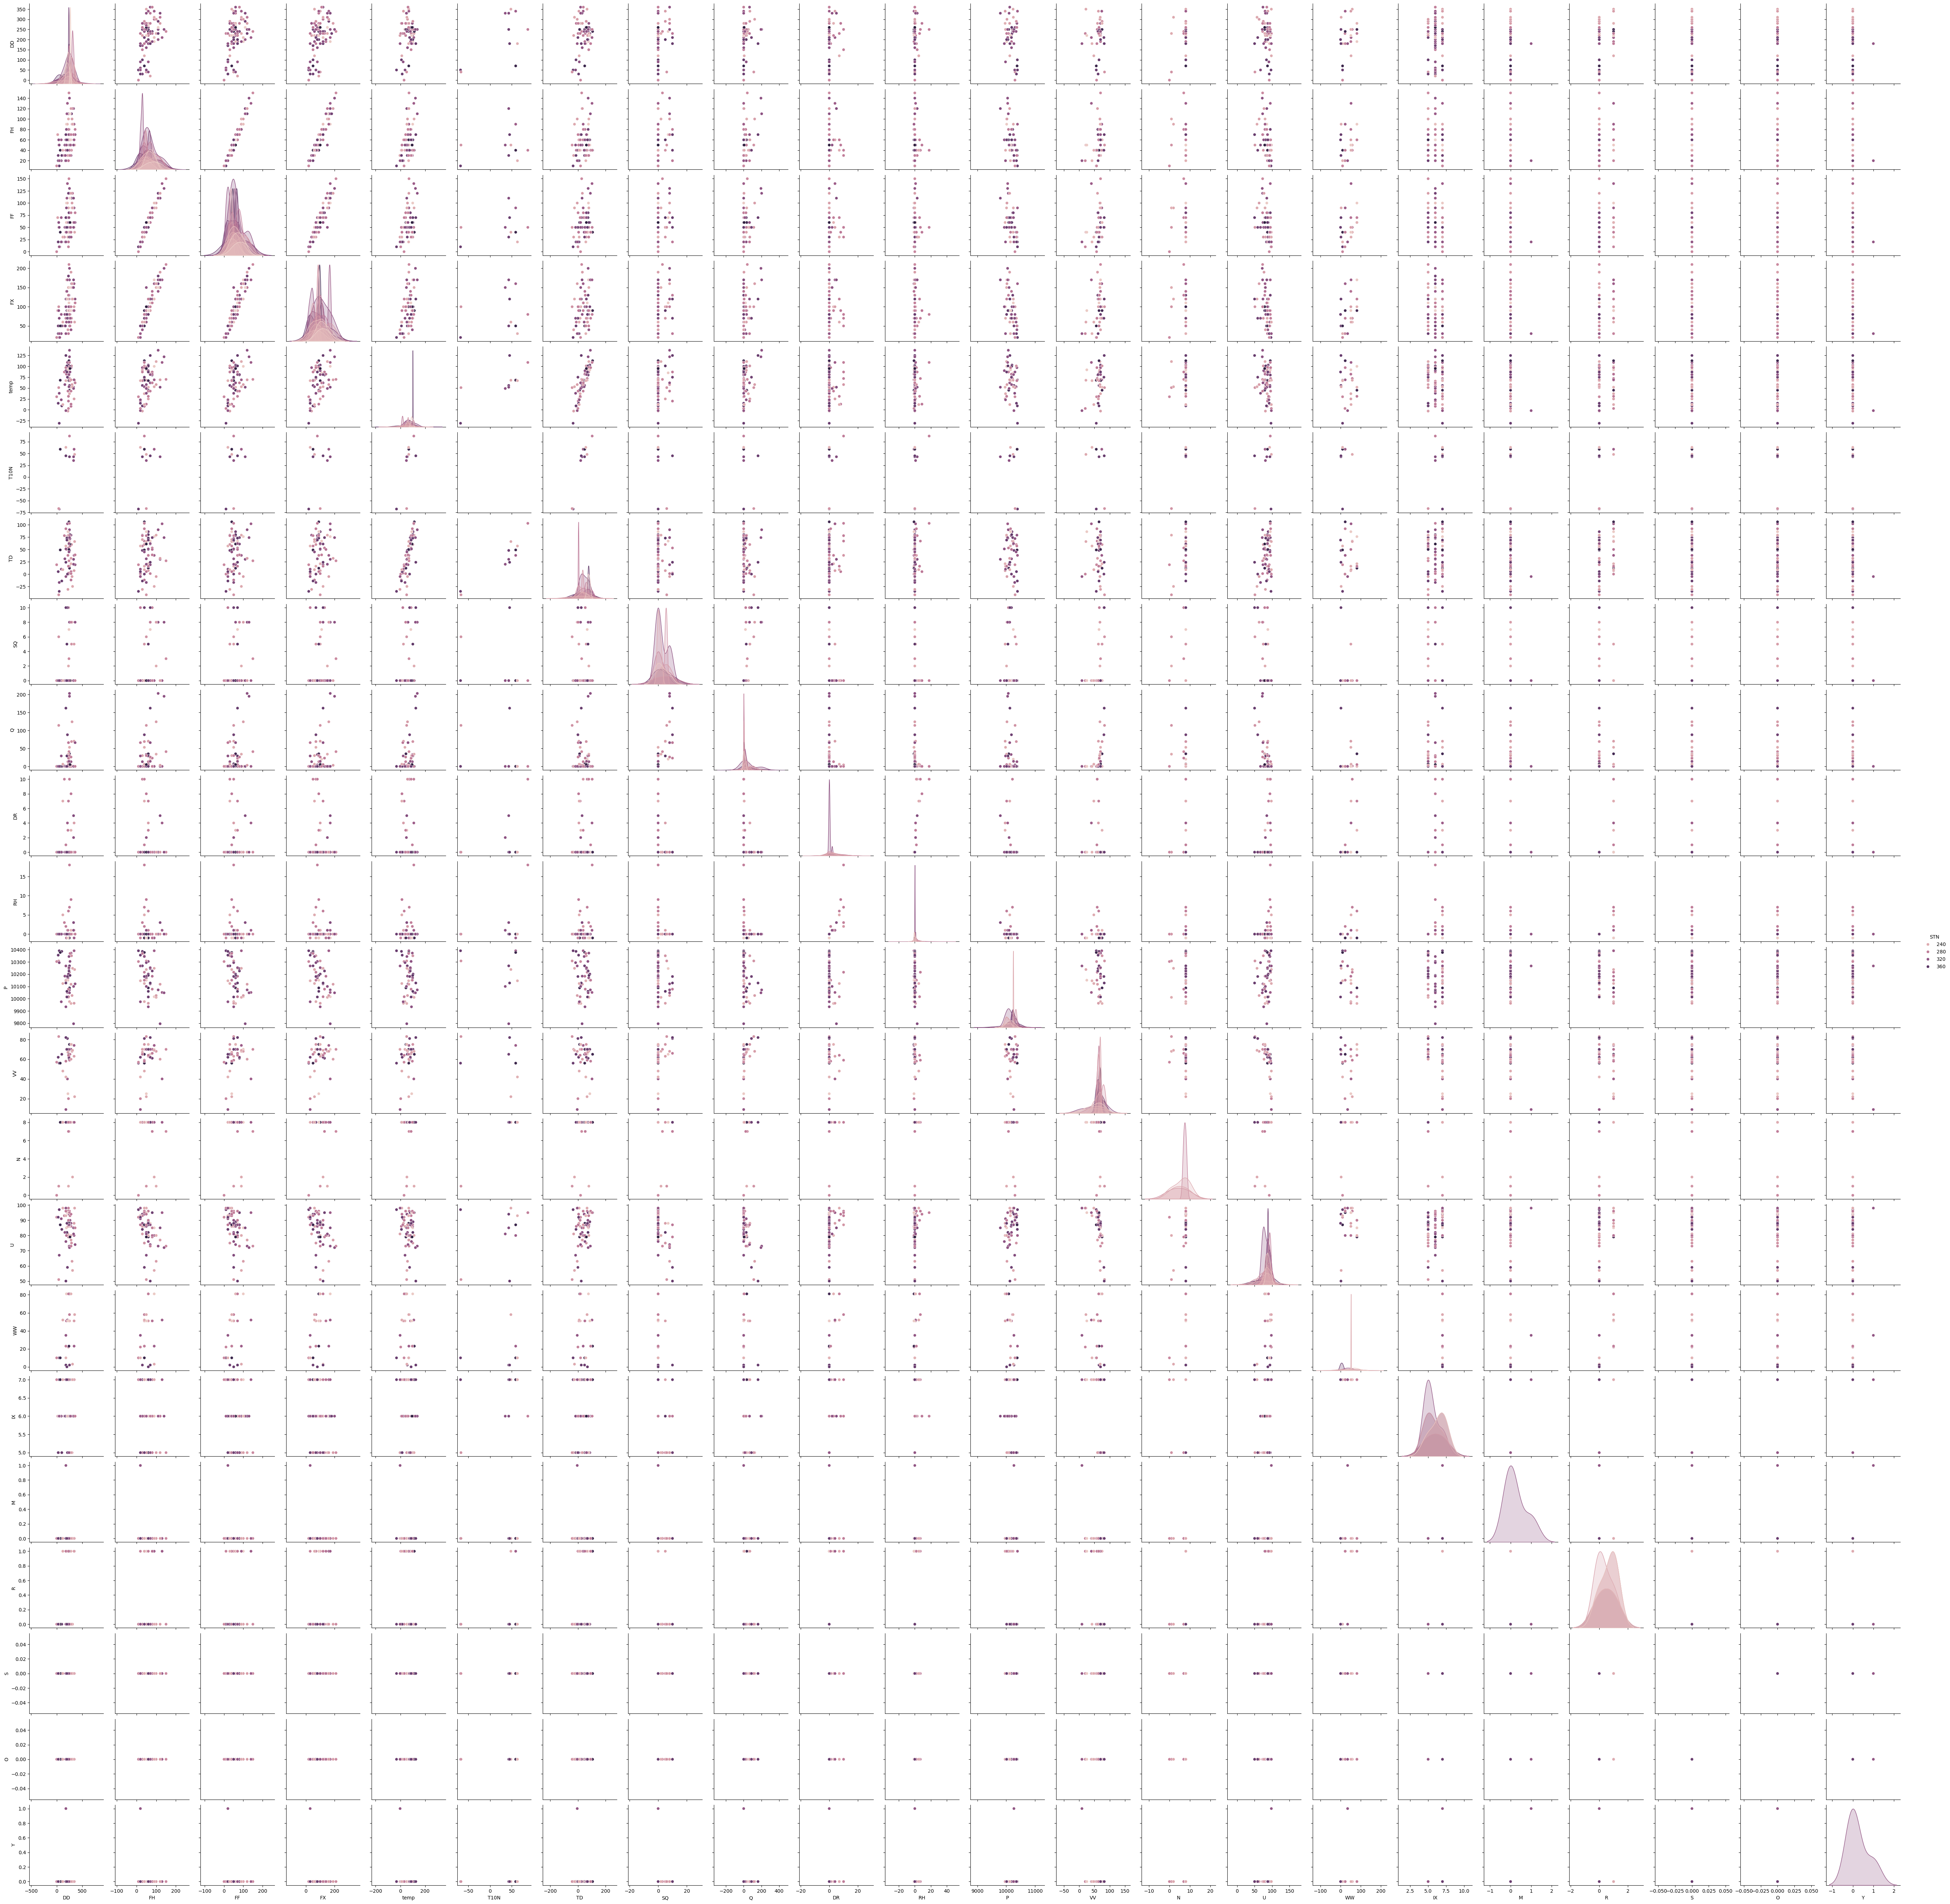

In [20]:
plt.figure(figsize=(20,20))
display(weather_2023.sample(frac=0.001))
sns.pairplot(weather_2023.sample(frac=0.001), hue='STN')

### 🏟️ trein station 

<Axes: >

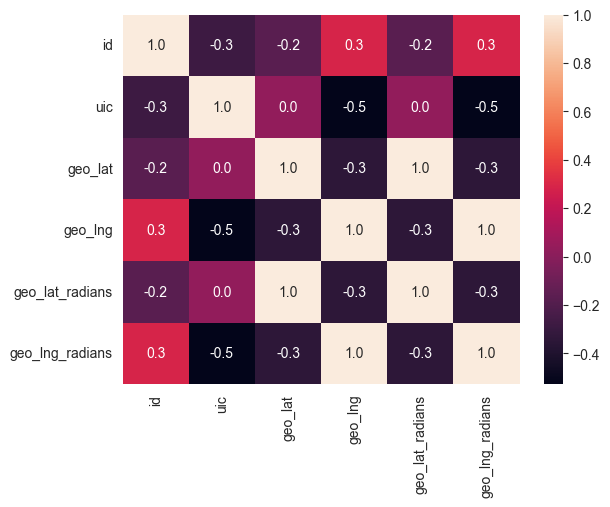

In [204]:
corr = train_station_locations.select_dtypes(include=['int32', 'int64', 'float64']).corr()

sns.heatmap(corr, cbar=True, annot=True, fmt=".1f")

dit was meer om te kijken of ik iets kreeg. maar het geeft een goed voorbeeld van de gegevens.

# 🛠️ Preprocessing

hier ga ik kijken of ik de datasets kan samenvoegen, zodat ik 1 volledige dataset krijg met mijn informatie.

### 🚄 trein verkeer 

### 🌥️ het weer

### 🏟️ trein station 
